# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [2]:
# Loading mnist data
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Transforming to 2d format, from: (784*1) -> (28*28)
image = data.iloc[3] # selecting image at index 3
image = np.array(image).astype("float32")

image = np.reshape(image, (28, 28)) # reshaping
image = image / 255 # skalerer

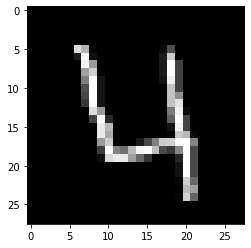

In [4]:
plt.imshow(image, cmap = "gray");

In [5]:
# noising input 
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

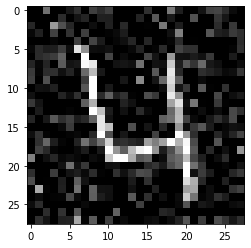

In [6]:
plt.imshow(noisy_image, cmap = "gray");

# Data Preparation 

In [7]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

![](dataset.png)

In [8]:
# creating own custom dataset 
# Basically doing the same as "exploring data", but here for alle rows instead of only 1
class mnist_ae_dataset(Dataset):
    
    def __init__(self, csv_file, noise_factor = 0.2, transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx] # selecting row
        img = np.array(img)
        img = np.reshape(img, (28, 28, 1)) / 255 # chanel = 1
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (noisy_img, img)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [9]:
trainset = mnist_ae_dataset("mnist_dataset.csv", transform = ToTensorForAE())

In [10]:
print("Size of trainset : {}".format(len(trainset)))

Size of trainset : 42000


In [11]:
noisy_img,org_img = trainset[18]

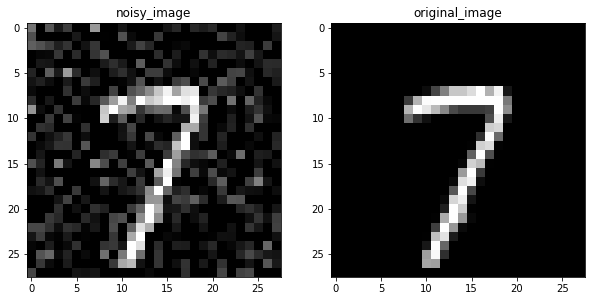

In [12]:
show_image(noisy_img, org_img) # from helper file 

# Load dataset into batches

In [13]:
# importing data loader
from torch.utils.data import DataLoader

In [14]:
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)

In [15]:
dataiter = iter(trainloader)
noisy_img, org_img = dataiter.next()

print("Shape of loading one batch : {}".format(noisy_img.shape)) # Could equally well have used org_img
# 16 is the number og batches, 1 the number of channels, then hight and wides

print("Total number of batches : {}".format(len(trainloader))) # number of batches
print("Total number of examples : {}".format(len(trainloader.dataset)))

Shape of loading one batch : torch.Size([16, 1, 28, 28])
Total number of batches : 2625
Total number of examples : 42000


# Create AutoEncoder Model

In [23]:
from torch import nn
from torchsummary import summary

In [39]:
# Creating the encoder model
def Encoder():
    
    enc = nn.Sequential(
    
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3), padding = 1), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2)),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), padding = 1), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2))
                  
    )
    
    return(enc)

In [42]:
# Creating decoder model
def Decoder():
    
    dec = nn.Sequential(
    
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2, 2), stride = 2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2, 2), stride = 2),
        nn.Sigmoid()
    )
    
    return(dec)

In [43]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, inp_imgs):
        
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        
        return(decoder_out) # returns the reconstructed image
    
# initializing model
model = AutoEncoder()
model
 

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [44]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

# Plot Results